# Problem statement
### Build a logistic regression model to predict whether salaries are greater than 90K or not in Boston for Data Scientist positions, depending on years of experience (none, 1, 2, 3, 4+), and presence of keywords in the job description like PhD, Python and Startup

# Data cleaning

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from patsy import dmatrices
from sklearn.cross_validation import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
# Make individual dataframes
salary = pd.read_csv("id_salary.csv")
years = pd.read_csv("id_years.csv")
phd = pd.read_csv("phd_df.csv", encoding = "cp1252")
startup = pd.read_csv("startup_df.csv")
python = pd.read_csv("id_and_Python.csv")

In [17]:
# Delete extra columns
del salary["Unnamed: 0"]
del years["Unnamed: 0"]
del phd["Unnamed: 0"]
del phd["title"]
del startup["Unnamed: 0"]
del python["Unnamed: 0"]

In [18]:
# ensure all dataframes have same index column names
phd = phd.rename(columns = {"job_id": "id", "has_phd": "phd"})
salary = salary.rename(columns = {"id": "id", "over_90k": "salary"})
startup = startup.rename(columns = {"id": "id", "has_startup": "startup"})
python = python.rename(columns = {"id": "id", "Python": "python"})

In [144]:
# Merge salary and years, drop NaN, convert years to type string
df = salary.merge(years, on = "id", how = "left")
df = df.dropna()
df["years"] = df["years"].replace(0, "0")
df["years"] = df["years"].replace(4, "4+ yrs")
df["years"] = df["years"].replace(1, "1 yr")
df["years"] = df["years"].replace(2, "2 yrs")
df["years"] = df["years"].replace(3, "3 yrs")

# Merge phd, fill NaNs with 0
df = df.merge(phd, on = "id", how = "left")
df["phd"] = df["phd"].fillna(0)

# Merge startup, fill NaNs with 0
df = df.merge(startup, on = "id", how = "left")
df["startup"] = df["startup"].fillna(0)

# Merge python, fill NaNs with 0
df = df.merge(python, on = "id", how = "left")
df["python"] = df["python"].fillna(0)

In [145]:
# Remove duplicates
df = df.drop_duplicates()
df.head()

,id,salary,years,phd,startup,python
0,jl_85c4e91c561780aa,0,1 yr,0.0,0.0,1.0
1,jl_85c4e91c561780aa,0,3 yrs,0.0,0.0,1.0
2,jl_e632343c455d80f9,0,0,0.0,0.0,1.0
3,jl_1b5a168dfc7b2712,0,3 yrs,0.0,0.0,0.0
4,jl_05654b2739edb3dc,0,0,0.0,1.0,0.0


In [146]:
df["years"].unique()

array(['1 yr', '3 yrs', '0', '4+ yrs', '2 yrs'], dtype=object)

# Exploratory data analysis

In [143]:
# Export to csv for Tableau plotting
df.to_csv("salary3.csv")

#### More openings with >90k salaries as years of experience increases
<img src = "SalaryYears.png" width="500" height="300">
#### More openings with >90k salaries with mention of "Python", "PhD" or "Startup" in job description
<img src = "SalaryPython.png" width="300" height="200">
<img src = "SalaryPhD.png" width="300" height="200">
<img src = "SalaryStartup.png" width="300" height="200">

# Data prep for logistic regression

In [147]:
# Categorize predictors
y, X = dmatrices("salary ~ C(phd) + C(startup) + C(python) + C(years)", df, return_type = "dataframe")
X.head()

,Intercept,C(phd)[T.1.0],C(startup)[T.1.0],C(python)[T.1.0],C(years)[T.1 yr],C(years)[T.2 yrs],C(years)[T.3 yrs],C(years)[T.4+ yrs]
0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [148]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y)

# Model 1: Logistic regression (C=1, L2 penalty)

In [149]:
# Build model
logreg1 = LogisticRegression()
model1 = logreg1.fit(X_train, y_train)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [150]:
# Coefficients
col = X_train.columns
for i in range(len(col)):
    print("Coef: {}, Value: {}".format(col[i], logreg1.coef_[0][i]))

Coef: Intercept, Value: -0.3914172002377899
Coef: C(phd)[T.1.0], Value: 0.5329440380465147
Coef: C(startup)[T.1.0], Value: 1.0311908340506193
Coef: C(python)[T.1.0], Value: 1.3396566642148873
Coef: C(years)[T.1 yr], Value: -0.39671733783310176
Coef: C(years)[T.2 yrs], Value: 0.08804835354301482
Coef: C(years)[T.3 yrs], Value: 0.5059452855313716
Coef: C(years)[T.4+ yrs], Value: 1.2487307491972117


In [151]:
# Predict test set
y_pred = logreg1.predict(X_test)

In [152]:
# Metrics
print(metrics.classification_report(y_test, y_pred))
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.68      0.63      0.66       100
        1.0       0.69      0.74      0.71       111

avg / total       0.69      0.69      0.69       211

Accuracy:  0.687203791469


# Model2: Logistic Regression, with GridSearchCV to search for optimal regularization parameter and penalty

In [153]:
# Build model
logreg2 = LogisticRegression()

In [154]:
# GridsearchCV
grid = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], "penalty": ["l1", "l2"]}
grid_search = GridSearchCV(logreg2, grid, cv = 6, scoring = "accuracy")
grid_search.fit(X_train, np.array(y_train["salary"]))
grid_search.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [155]:
# Best accuracy
grid_search.best_score_

0.69715447154471544

In [156]:
# Predict test set
y_pred2 = grid_search.predict(X_test)
print(metrics.classification_report(y_test, y_pred2))
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred2))

             precision    recall  f1-score   support

        0.0       0.68      0.63      0.65       100
        1.0       0.69      0.73      0.71       111

avg / total       0.68      0.68      0.68       211

Accuracy:  0.682464454976


In [157]:
# Coefficients
col = X_train.columns
for i in range(len(col)):
    print("Coef: {}, Value: {}".format(col[i], grid_search.best_estimator_.coef_[0][i]))

Coef: Intercept, Value: -0.20721043212068593
Coef: C(phd)[T.1.0], Value: 0.41088236998652145
Coef: C(startup)[T.1.0], Value: 0.3774939929410895
Coef: C(python)[T.1.0], Value: 0.8662332979417542
Coef: C(years)[T.1 yr], Value: -0.2533030336188707
Coef: C(years)[T.2 yrs], Value: -0.08035938491224999
Coef: C(years)[T.3 yrs], Value: 0.2010328501642917
Coef: C(years)[T.4+ yrs], Value: 0.7740366695028221


# Conclusions
#### The model predicts new data with ~68% accuracy. The following factors correlate with higher (>90k) salaries (in decreasing order of importance):
1. Mention of Python in job description
2. 4+ years of experience requirement
3. Mention of PhD in job description
4. Mention of startup in job description

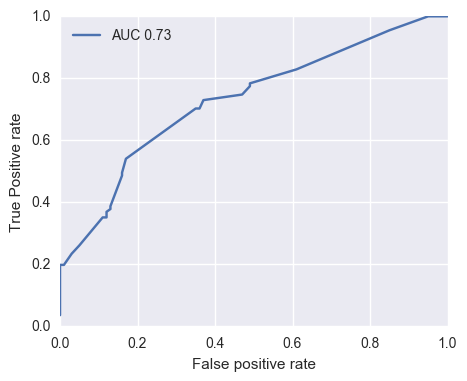

In [177]:
# ROC curve
test_score2 = grid_search.decision_function(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_score2)
area = metrics.roc_auc_score(y_test, test_score2)
plt.figure(figsize = (5,4))
plt.xlabel("False positive rate")
plt.ylabel("True Positive rate")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(handles = [plot1], loc = "best")
plot1, = plt.plot(fpr, tpr, label = "AUC %0.2f"%area)
plt.show()